# Tareas 5/11

1. $\langle E \rangle_{rad}^0\langle \sigma v \rangle_{rad}^0$ Gráficar tabla II de lechte en func temp, y comparar con los obtenidados de Cherab.
2. Construir el  $\langle E \rangle_{ion}\langle \sigma v \rangle_{ion}$ de la eq. 14 de Lechte (cuidado m^3 / s) y hacer plot de temperaturas. Comparar con los datos obtenidos de cherab.
3. Tratar de hacer lo mismo con el Helio.
4. Encontrar los términos $\langle E \rangle_{rec}\langle \sigma v \rangle_{rec}$, $\langle E \rangle_{ion_2}\langle \sigma v \rangle_{ion_2}$ y $\langle E \rangle_{rad}^i\langle \sigma v \rangle_{rad}^i$.


## Condiciones de Frontera (Pendiente)
* Definir condiciones de frontera clásicas (las más sencillas) que nos permitan generar las funciones, pensando en el entrenamiento del PINN. Ej, elegir temperatura y densidad fijas en frontera. 
* Definir perfil de densidad y/o temperatura en la frontera que nos den libertad para parámetros que nos ayuden. 

### Casos:
1. Densidad y temperatura constante en los bordes
2. Gradiente de temperatura y densidad constante en los bordes y núcleo cero.
3. Flujo de partículas en el borde Robin, Flujo de energía.

$$
\begin{cases}
    \nabla n (r)|_R \propto n(R)\\
    \nabla T(r) |_R \propto T(R)
\end{cases}
$$

4. Energía interna.



# Tareas 12/11

1. Revisar ajustes.
2. Error cuadrático medio en todas las curvas. 
3. Arreglar casos de extrapolación.
4. Hacer una introdución de los PINN en el LaTex y resumen en notebook.
5. ¿Qué nos falta identificar para el PINN físicamente/computacional para que el modelo este completo? (Pregunta clave)

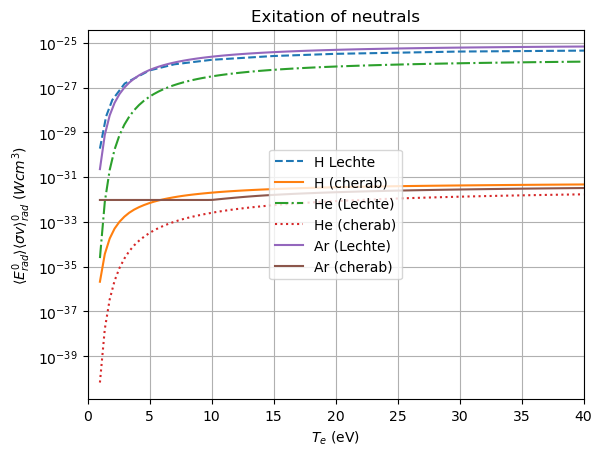

In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt

from cherab.core.atomic import hydrogen, helium, argon
from cherab.openadas import OpenADAS

#Function to compute the dissipate power
def Esigmav(Te, E, coeff_array):
    m = len(coeff_array)
    log_terms = np.array([ np.log(Te)**i for i in range(m) ])
    arg = np.dot(coeff_array, log_terms)

    return E*np.exp(arg)

#Datos tabla II
conv_fact = 1.6e-13
Te = np.array([1.,1.5,2.,3.,5.,7,10.,15.,20.,30.,50.,70.], dtype= np.float64)
EsigmavH_rad = np.array([1.87e-30, 5.14e-29, 2.8e-28, 1.51e-27, 5.81e-27, 1.09e-26, 1.73e-26, 2.56e-26, 3.2e-26, 4.05e-26, 4.9e-26, 5.27e-26])
E_rad = np.array([19.8, 11.5])
E_ion = [13.6, 24.6, 15.8]
T_array = np.linspace(1.0, 40.0, 100)

adas = OpenADAS(permit_extrapolation=True)

h_ion_rate = adas.ionisation_rate(hydrogen, 0)
h_rate = np.array([ h_ion_rate.evaluate(1e19, T ) for T in T_array])

he_ion_rate = adas.ionisation_rate(helium, 0)
he_rate = np.array([ he_ion_rate.evaluate(1e19, T ) for T in T_array])

ar_ion_rate = adas.ionisation_rate(argon, 0)
ar_rate = np.array([ ar_ion_rate.evaluate(1e19, T ) for T in T_array])

h_rec = adas.recombination_rate(hydrogen, 1)
h_rec_rate = np.array([ h_rec.evaluate(1e19, T ) for T in T_array])

h_rad0 = adas.line_radiated_power_rate(hydrogen,0)
h_rad0_rate = np.array([ h_rad0.evaluate(1e19, T ) for T in T_array])

he_rad0 = adas.line_radiated_power_rate(helium,0)
he_rad0_rate = np.array([ he_rad0.evaluate(1e19, T ) for T in T_array])

ar_rad0 = adas.line_radiated_power_rate(argon, 0)
ar_rad0_rate = np.array([ ar_rad0.evaluate(1e19, T ) for T in T_array])

he_radi = adas.line_radiated_power_rate(helium,1)
he_radi_rate = np.array([ he_rad0.evaluate(1e19, T ) for T in T_array])

ar_radi = adas.line_radiated_power_rate(argon, 1)
ar_radi_rate = np.array([ ar_rad0.evaluate(1e19, T ) for T in T_array])

coeffs_ion = pl.read_csv('coeff_rad0.csv').to_numpy()

plt.plot(Te, EsigmavH_rad,'--', label='H Lechte')
plt.plot(T_array, h_rad0_rate, label= 'H (cherab)')
plt.plot(T_array, Esigmav(T_array, E_rad[0] , coeffs_ion[:,0])*conv_fact, '-.',label='He (Lechte)');
plt.plot(T_array, he_rad0_rate, ':',label='He (cherab)');
plt.plot(T_array, Esigmav(T_array, E_rad[1], coeffs_ion[:,1])*conv_fact, label='Ar (Lechte)');
plt.plot(T_array, ar_rad0_rate,label='Ar (cherab)');
plt.yscale('log')
plt.xlabel(r'$T_e$ (eV)')
plt.title('Exitation of neutrals')
plt.xlim([0,40])
#plt.ylim([1e-30,1e-25])
plt.ylabel(r'$\langle E_{rad}^0 \rangle\langle \sigma v \rangle_{rad}^0$ ($W cm^3$)');
plt.legend(loc='center');
plt.grid(True)

### En la figura anterior se forzaron los factes para que calzaran, tengo que averiguar por que hay un factor de $10^6$ ahí.

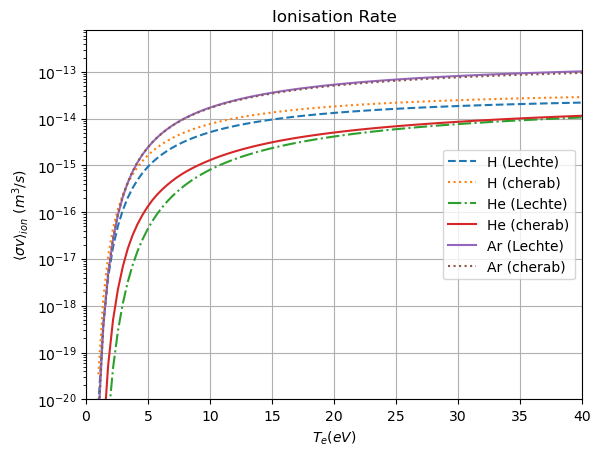

In [2]:
coeffs_ion = pl.read_csv('coeff_ion.csv').to_numpy()

plt.plot(T_array, Esigmav(T_array, 1, coeffs_ion[:,0]),'--', label='H (Lechte)');
plt.plot(T_array, h_rate, ':',label='H (cherab)');
plt.plot(T_array, Esigmav(T_array, 1, coeffs_ion[:,1]), '-.',label='He (Lechte)');
plt.plot(T_array, he_rate, label='He (cherab)')
plt.plot(T_array, Esigmav(T_array, 1, coeffs_ion[:,2]), label='Ar (Lechte)');
plt.plot(T_array, ar_rate,':', label='Ar (cherab)')
plt.ylabel(r'$\langle \sigma v\rangle_{ion}$ $(m^3/s)$')
plt.xlabel(r'$T_e(eV)$')
plt.yscale('log')
plt.ylim([1e-20,8e-13])
plt.xlim([0,40])
plt.title('Ionisation Rate')
plt.legend(loc='center right')
plt.grid(True)

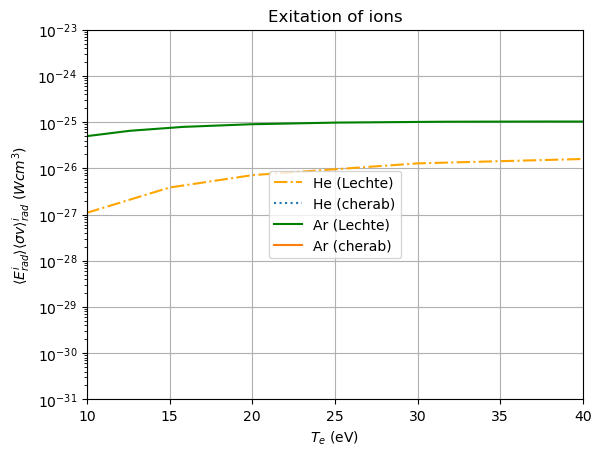

In [3]:
TeHe = np.array([0.2,0.3,0.5,0.7,1.0,1.5,2.0,3.0,5.0,7.0,10.0,15.0,20.0,30.0,50.0,70.0])
TeAr = np.array([1.,1.26,1.58,1.99,2.51,3.16,3.98,5.01,6.31,7.94,9.99,12.6,15.8,19.9,25.1,31.6,37.8,50.1,63.,79.4])
EsigmavHe_radi = np.array([1.0e-74, 1.0e-74, 2.33e-61, 6.68e-51, 2.4e-43,2.1e-37,1.41e-34,1.14e-31, 2.21e-29, 2.08e-28,1.09e-27,3.84e-27, 7.11e-27,1.28e-26,1.98e-26,2.34e-26])
EsigmavAr_radi = np.array([3.72e-31, 4.79e-30, 3.69e-29,  1.92e-28, 7.43e-28, 2.27e-27, 5.68e-27,1.20e-26,2.17e-26,3.47e-26, 4.97e-26, 6.49e-26, 7.88e-26, 8.99e-26, 9.77e-26, 1.02e-25, 1.03e-25,1.02e-25, 9.82e-26, 9.33e-26])

plt.plot(TeHe, EsigmavHe_radi, '-.', color='orange',label='He (Lechte)');
plt.plot(T_array, he_radi_rate, ':',label='He (cherab)');
plt.plot(TeAr, EsigmavAr_radi, 'g', label='Ar (Lechte)');
plt.plot(T_array, ar_radi_rate,label='Ar (cherab)');
plt.yscale('log')
plt.xlabel(r'$T_e$ (eV)')
plt.title('Exitation of ions')
plt.xlim([10,40])
plt.ylim([1e-31, 1e-23])
plt.ylabel(r'$\langle E_{rad}^i \rangle\langle \sigma v \rangle_{rad}^i$ ($W cm^3$)');
plt.legend(loc='center');
plt.grid(True)

### En la figura anterior se forzaron los factes para que calzaran, tengo que averiguar por que hay un factor de $10^6$ ahí.

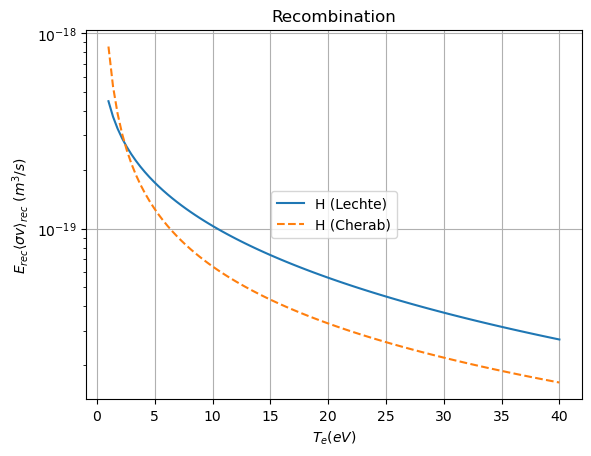

In [4]:
def sigmav_rec(Te):
    Z = 13.6 / Te
    return 1.27e-19*np.power(Z, 1.5) / (Z + 0.59) 

rec_rate = sigmav_rec(T_array)
plt.plot(T_array, rec_rate, label='H (Lechte)');
plt.plot(T_array, h_rec_rate, '--',label='H (Cherab)');
plt.ylabel(r'$E_{rec}\langle \sigma v\rangle_{rec}$ $(m^3/s)$')
plt.xlabel(r'$T_e(eV)$')
plt.yscale('log')
plt.title('Recombination')
plt.legend(loc='center')
plt.grid(True)

## Recombination error

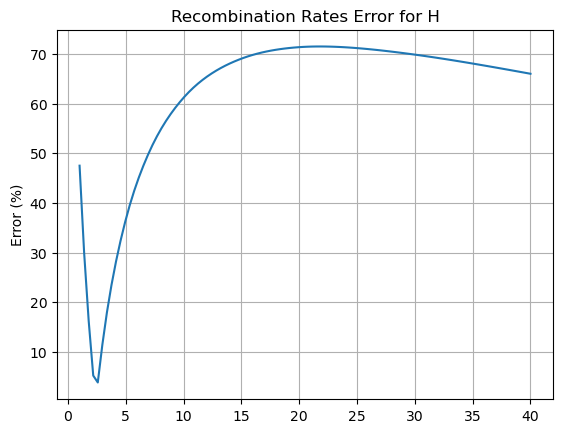

71.54069817705891

In [5]:
error_rec = abs(h_rec_rate - rec_rate)/h_rec_rate * 100

plt.plot(T_array,error_rec)
plt.grid(True)
plt.ylabel(r'Error (%)')
plt.title('Recombination Rates Error for H')
plt.show();
max(error_rec)

## PINNs Oscilador Armónico

$$ m \ddot{u} + \mu \dot{u} + ku = 0$$ 

Definición de constantes

$$ \delta = \frac{\mu}{2m}, \quad \omega_0^2 = \frac{k}{m}, \quad{\delta < \omega_0}$$

Condiciones iniciales

$$ u(t = 0) = 1, \quad \dot{u}(t = 0) = 0$$

Solución exacta

$$u(t) = e^{-\delta t}[2A\cos{(\phi + \omega t)}], \quad \text{con} \quad \omega^2 = \omega_0^2 - \delta^2$$

In [6]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [7]:
def exact_solution(d, w0, t):
    "Defines the analytical solution to the under-damped harmonic oscillator problem above."
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*t)
    exp = torch.exp(-d*t)
    u = exp*2*A*cos
    return u

class FCN(nn.Module):
    "Defines a standard fully-connected network in PyTorch"

    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        self.fcs = nn.Sequential(*[
                        nn.Linear(N_INPUT, N_HIDDEN),
                        activation()])
        self.fch = nn.Sequential(*[
                        nn.Sequential(*[
                            nn.Linear(N_HIDDEN, N_HIDDEN),
                            activation()]) for _ in range(N_LAYERS-1)])
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

0.06044205650687218 0.15345802903175354 0.12195593863725662


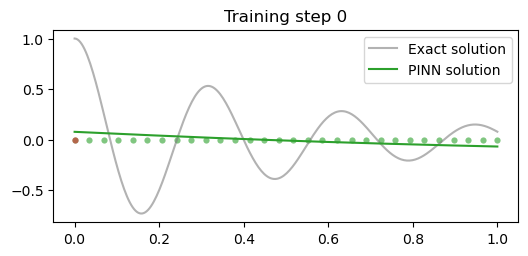

0.24402110278606415 4.427809238433838 94.49955749511719


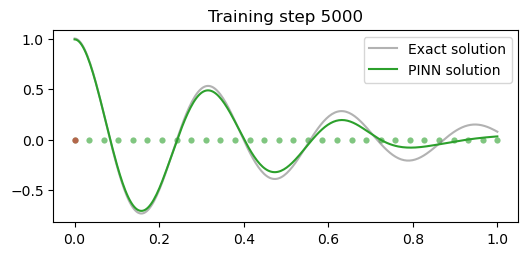

0.2655717134475708 4.857725143432617 104.5623779296875


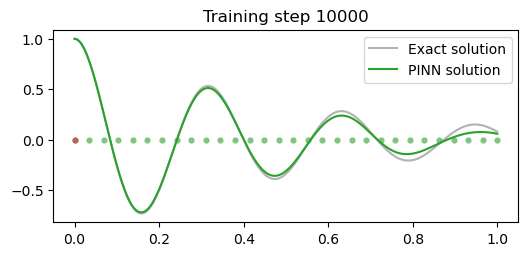

0.284871906042099 5.223545551300049 111.85289001464844


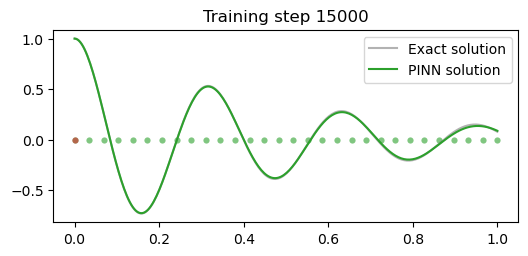

In [8]:
torch.manual_seed(123)

# define a neural network to train
# TODO: write code here
pinn = FCN(1,1,32,3)

# define boundary points, for the boundary loss
# TODO: write code here
t_boundary = torch.tensor(0.).view(-1,1).requires_grad_(True)

# define training points over the entire domain, for the physics loss
# TODO: write code here
t_physics = torch.linspace(0,1,30).view(-1,1).requires_grad_(True)

# train the PINN
d, w0 = 2, 20
mu, k = 2*d, w0**2
t_test = torch.linspace(0,1,300).view(-1,1)
u_exact = exact_solution(d, w0, t_test)
optimiser = torch.optim.Adam(pinn.parameters(),lr=1e-3)
for i in range(15001):
    optimiser.zero_grad()

    # compute each term of the PINN loss function above
    # using the following hyperparameters:
    lambda1, lambda2 = 1e-1, 1e-4

    # compute boundary loss
    # TODO: write code here
    u = pinn(t_boundary)
    loss1 = (torch.squeeze(u) - 1)**2
    dudt = torch.autograd.grad(u, t_boundary, torch.ones_like(u), create_graph=True)[0]
    loss2 = (torch.squeeze(dudt) - 0)**2

    # compute physics loss
    # TODO: write code here
    u = pinn(t_physics)
    dudt = torch.autograd.grad(u, t_physics, torch.ones_like(u), create_graph=True)[0]
    d2udt2 = torch.autograd.grad(dudt, t_physics, torch.ones_like(dudt), create_graph=True)[0]
    loss3 = torch.mean((d2udt2 + mu*dudt + k*u)**2)

    # backpropagate joint loss, take optimiser step
    # TODO: write code here
    loss = loss1 + lambda1*loss2 + lambda2*loss3
    loss.backward()
    optimiser.step()

    # plot the result as training progresses
    if i % 5000 == 0:
        print(u.abs().mean().item(), dudt.abs().mean().item(), d2udt2.abs().mean().item())
        u = pinn(t_test).detach()
        plt.figure(figsize=(6,2.5))
        plt.scatter(t_physics.detach()[:,0],
                    torch.zeros_like(t_physics)[:,0], s=20, lw=0, color="tab:green", alpha=0.6)
        plt.scatter(t_boundary.detach()[:,0],
                    torch.zeros_like(t_boundary)[:,0], s=20, lw=0, color="tab:red", alpha=0.6)
        plt.plot(t_test[:,0], u_exact[:,0], label="Exact solution", color="tab:grey", alpha=0.6)
        plt.plot(t_test[:,0], u[:,0], label="PINN solution", color="tab:green")
        plt.title(f"Training step {i}")
        plt.legend()
        plt.show()

## PINN Duffin's Oscillator

Para un oscilador de Duffin dado por

$$ \ddot{x} + 2x + 2x^3 = 0, \quad x(0) = 1, \quad \dot{x}(0) = 0$$


La solución exacta está dada por: 

$$ x(t) = cn(2t, 1/2) $$

donde $cn(\xi; \alpha) = \cos\phi$ es una función eliptica de Jacobi tal que,

$$ \xi = \int\limits_0^\phi \frac{d\theta}{\sqrt{1 - \alpha^2\sin^2{\theta}}}$$

Using device: mps
Step      0 | Loss = 1.051e+00 | MSE = 4.778e-01


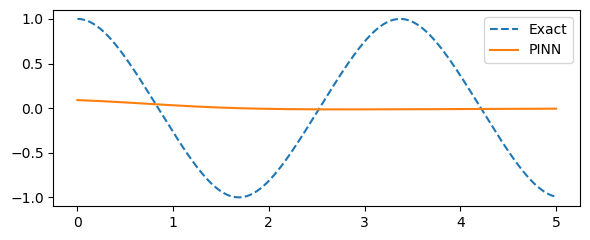

Step  10000 | Loss = 1.792e-05 | MSE = 9.530e-01


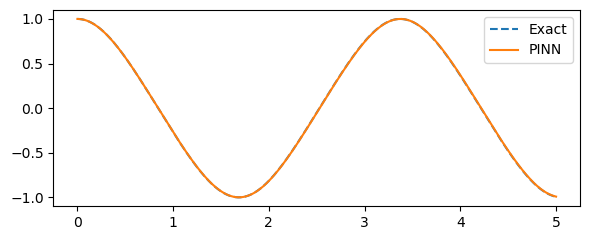

Step  20000 | Loss = 8.858e-06 | MSE = 9.537e-01


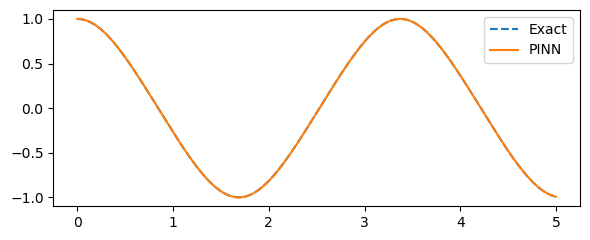

Step  30000 | Loss = 6.705e-06 | MSE = 9.535e-01


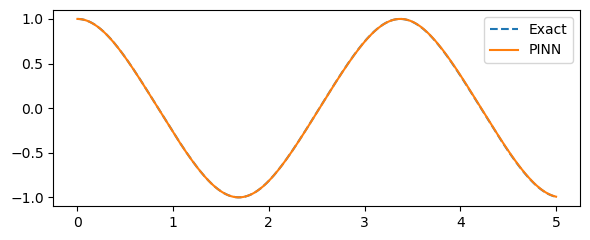

Step  40000 | Loss = 2.649e-06 | MSE = 9.537e-01


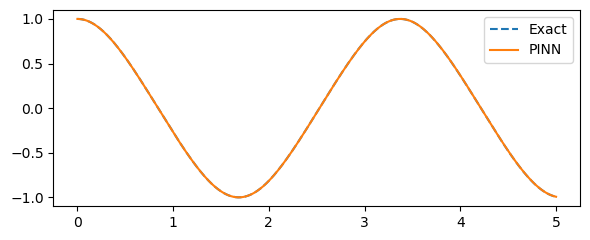

Step  50000 | Loss = 1.074e-04 | MSE = 9.529e-01


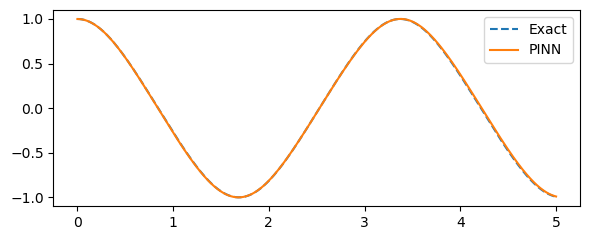

Step  60000 | Loss = 2.294e-04 | MSE = 9.530e-01


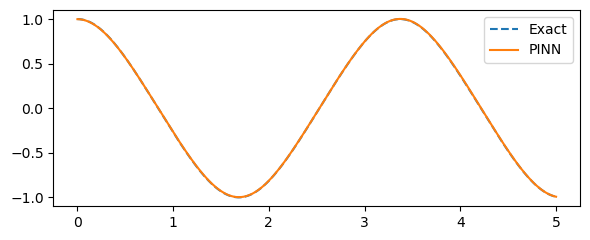

In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from scipy.special import ellipj

if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print("Using device:", device)

torch.manual_seed(123)
torch.set_default_dtype(torch.float32)

def exact_solution(t):
    t_cpu = t.detach().cpu().numpy()
    cn = ellipj(2.0 * t_cpu, 0.25)[1]
    return torch.tensor(cn, dtype=t.dtype, device=t.device)

# Neural Network
class FCN(nn.Module):
    def __init__(self, hidden=64, layers=4):
        super().__init__()
        act = nn.Tanh
        modules = [nn.Linear(1, hidden), act()]
        for _ in range(layers - 1):
            modules += [nn.Linear(hidden, hidden), act()]
        modules += [nn.Linear(hidden, 2)]
        self.net = nn.Sequential(*modules)

    def forward(self, t):
        return self.net(t)

# Model
model = FCN(hidden=64, layers=4).to(device)

# Time grids
t0 = torch.tensor([[0.0]], device=device, requires_grad=True)

t_phys = torch.linspace(0.0, 5.0, 400, device=device).view(-1, 1)
t_phys.requires_grad_(True)

t_test = torch.linspace(0.0, 5.0, 600, device=device).view(-1, 1)
x_exact = exact_solution(t_test)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Loss function 
def pinn_loss():
    # Initial condition
    uv0 = model(t0)
    x0, v0 = uv0[:, 0:1], uv0[:, 1:2]
    loss_ic = (x0 - 1.0)**2 + v0**2

    # Physics
    uv = model(t_phys)
    x, v = uv[:, 0:1], uv[:, 1:2]

    dxdt = torch.autograd.grad(
        x, t_phys, torch.ones_like(x), create_graph=True
    )[0]

    dvdt = torch.autograd.grad(
        v, t_phys, torch.ones_like(v), create_graph=True
    )[0]

    res_x = dxdt - v
    res_v = dvdt + 2.0*x + 2.0*x**3
    loss_phys = torch.mean(res_x**2 + res_v**2)

    # Energy conservation
    H = 0.5*v**2 + x**2 + 0.5*x**4
    H0 = (0.5*v0**2 + x0**2 + 0.5*x0**4).detach()
    loss_energy = torch.mean((H - H0)**2)

    return loss_ic + loss_phys + loss_energy


# Training
for i in range(60001):
    optimizer.zero_grad()
    loss = pinn_loss()
    loss.backward()
    optimizer.step()

    if i % 10000 == 0:
        with torch.no_grad():
            x_pred = model(t_test)[:, 0]
            mse = torch.mean((x_pred - x_exact)**2).item()

        print(f"Step {i:6d} | Loss = {loss.item():.3e} | MSE = {mse:.3e}")

        plt.figure(figsize=(6, 2.5))
        plt.plot(t_test.cpu()[:,0], x_exact.cpu(), "--", label="Exact")
        plt.plot(t_test.cpu()[:,0], x_pred.cpu(), label="PINN")
        plt.legend()
        plt.tight_layout()
        plt.show()